In [31]:
import mlflow
import optuna

from transforms import *
from utils import *
from models import *
from plots import *
from pathlib import Path
import time

import xgboost as xgb
from sklearn.model_selection import train_test_split


mlflow setup

In [2]:
tracking_uri = fr"http://127.0.0.1:8080"
metric_name = "auc"

In [3]:
mlflow.set_tracking_uri(tracking_uri)

In [4]:
X_us, y_us, test = init_datasets()

In [5]:
X_us = add_hour_day_from_clicktime(X_us)

In [6]:
grouping_categories = [
    # IP with every other base
    ['ip', 'channel'],
    ['ip', 'device'], 
    ['ip', 'os'],
    ['ip', 'app'],
    # IP and time features - must be done after adding time features
    ['ip', 'day', 'hour'],
    # Perhaps IP isn't as important
    ['app', 'channel'],
    # Triplet(s)
    ['ip', 'app', 'os'],
    # Quartet(s)
    ['ip', 'device', 'os', 'app']
    # Exclude all 5 together as these will be used for grouping
]
grouping_functions = ['nunique', 'cumcount']

In [7]:
X_us = add_groupby_user_features(X_us, grouping_categories=grouping_categories,
                                grouping_functions=grouping_functions)

In [8]:
X_us = add_next_click(X_us)

In [9]:
X_us.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'hour', 'day',
       'ip_channel_nunique', 'ip_channel_cumcount', 'ip_device_nunique',
       'ip_device_cumcount', 'ip_os_nunique', 'ip_os_cumcount',
       'ip_app_nunique', 'ip_app_cumcount', 'ip_day_hour_nunique',
       'ip_day_hour_cumcount', 'app_channel_nunique', 'app_channel_cumcount',
       'ip_app_os_nunique', 'ip_app_os_cumcount', 'ip_device_os_app_nunique',
       'ip_device_os_app_cumcount', 'user_hash', 'epoch_time', 'next_click'],
      dtype='object')

In [10]:
cols_to_bin = ['next_click'] # Just bin the one for now

In [11]:
X_us = log_bin_column(X_us, cols_to_bin)

c:\Users\Zade\Desktop\PythonStuff\adDetection\addetectionscripts\transforms.py:84: RuntimeWarning: divide by zero encountered in log2
  df[col] = np.log2(1 + df[col].values).astype(int)
c:\Users\Zade\Desktop\PythonStuff\adDetection\addetectionscripts\transforms.py:84: RuntimeWarning: invalid value encountered in log2
  df[col] = np.log2(1 + df[col].values).astype(int)
c:\Users\Zade\Desktop\PythonStuff\adDetection\addetectionscripts\transforms.py:84: RuntimeWarning: invalid value encountered in cast
  df[col] = np.log2(1 + df[col].values).astype(int)


In [12]:
X_us.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'hour', 'day',
       'ip_channel_nunique', 'ip_channel_cumcount', 'ip_device_nunique',
       'ip_device_cumcount', 'ip_os_nunique', 'ip_os_cumcount',
       'ip_app_nunique', 'ip_app_cumcount', 'ip_day_hour_nunique',
       'ip_day_hour_cumcount', 'app_channel_nunique', 'app_channel_cumcount',
       'ip_app_os_nunique', 'ip_app_os_cumcount', 'ip_device_os_app_nunique',
       'ip_device_os_app_cumcount', 'user_hash', 'epoch_time', 'next_click'],
      dtype='object')

In [13]:
# Drop the original click_time feature
X_us.drop(columns=['click_time'], inplace=True)

In [14]:
X_us.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'hour', 'day',
       'ip_channel_nunique', 'ip_channel_cumcount', 'ip_device_nunique',
       'ip_device_cumcount', 'ip_os_nunique', 'ip_os_cumcount',
       'ip_app_nunique', 'ip_app_cumcount', 'ip_day_hour_nunique',
       'ip_day_hour_cumcount', 'app_channel_nunique', 'app_channel_cumcount',
       'ip_app_os_nunique', 'ip_app_os_cumcount', 'ip_device_os_app_nunique',
       'ip_device_os_app_cumcount', 'user_hash', 'epoch_time', 'next_click'],
      dtype='object')

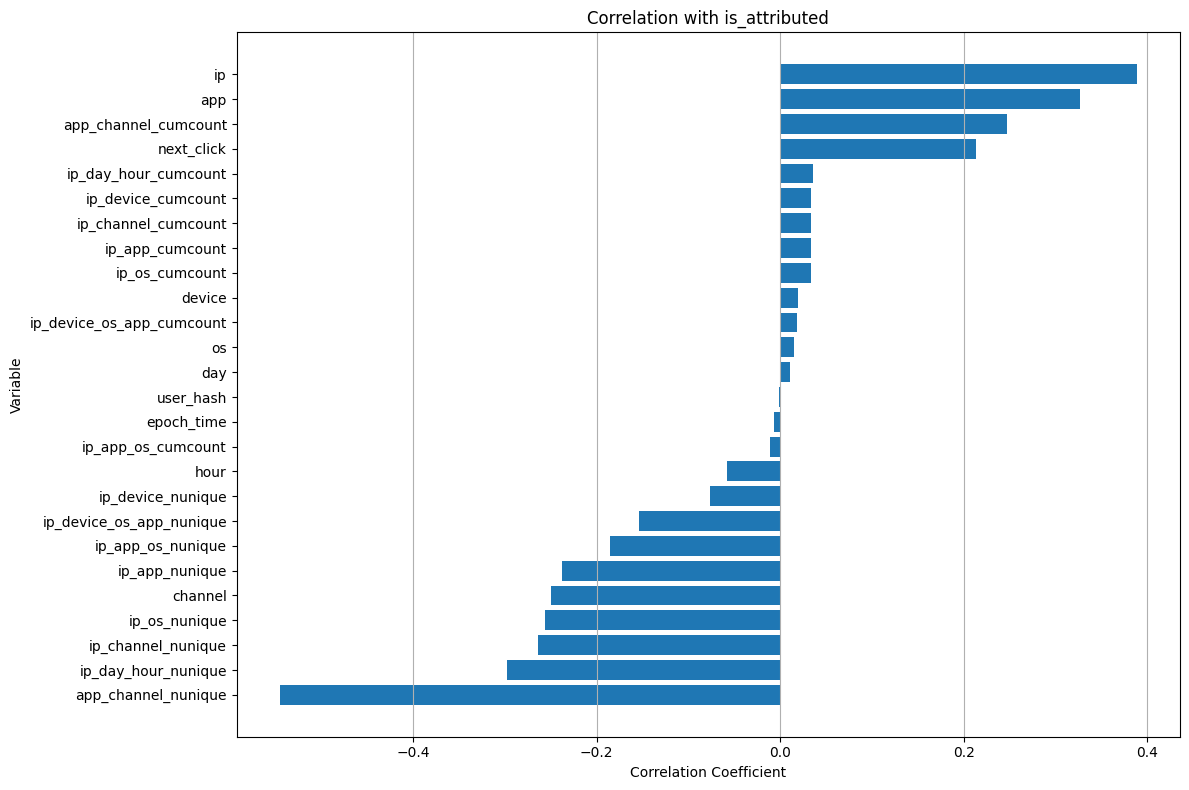

In [32]:
# correlation plot for mlflow
plot_correlation(X_us, y_us, target_col='is_attributed', save_path='test_corr_plot.png')

In [33]:
testing_plot = plot_correlation(X_us, y_us, target_col='is_attributed')

In [34]:
type(testing_plot)

matplotlib.figure.Figure

In [35]:
X_us.columns

Index(['ip', 'app', 'device', 'os', 'channel', 'hour', 'day',
       'ip_channel_nunique', 'ip_channel_cumcount', 'ip_device_nunique',
       'ip_device_cumcount', 'ip_os_nunique', 'ip_os_cumcount',
       'ip_app_nunique', 'ip_app_cumcount', 'ip_day_hour_nunique',
       'ip_day_hour_cumcount', 'app_channel_nunique', 'app_channel_cumcount',
       'ip_app_os_nunique', 'ip_app_os_cumcount', 'ip_device_os_app_nunique',
       'ip_device_os_app_cumcount', 'user_hash', 'epoch_time', 'next_click'],
      dtype='object')

In [36]:
experiment_id = get_or_create_experiment("Attributed Class.")

In [37]:
experiment_id

'605754130415395356'

Do an XGBoost model first

In [38]:
mlflow.set_experiment(experiment_id=experiment_id)

<Experiment: artifact_location='mlflow-artifacts:/605754130415395356', creation_time=1716228982515, experiment_id='605754130415395356', last_update_time=1716228982515, lifecycle_stage='active', name='Attributed Class.', tags={}>

In [39]:
test_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X_us, y_us, test_size=test_size, random_state=1233)

In [40]:
# Set to Dmatrix format for training speed
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)

In [41]:
# Set optuna to log only errors
optuna.logging.set_verbosity(optuna.logging.ERROR)

In [43]:
# Run name for mlflow logging
run_name = "second_attempt"

In [48]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Hparams
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'booster': trial.suggest_categorical("booster", ["gbtree", "dart"]),
            'lambda': trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            'alpha': trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            'max_depth': trial.suggest_int("max_depth", 1, 5),
            'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
            'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
            'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
        }
        
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        auc_score = roc_auc_score(y_val, preds)
    
        # Log to mlflow
        mlflow.log_params(params)
        mlflow.log_metric('auc', auc_score)
    return auc_score

In [49]:
def champion_callback_local(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [51]:
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Init Optuna
    study = optuna.create_study(direction='maximize') # Want to max our AUC
    
    # Optimize hparams
    study.optimize(objective, n_trials=50, callbacks=[champion_callback_local])
    
    # Log best params/score
    mlflow.log_params(study.best_params)
    mlflow.log_metric('best_auc', study.best_value)
    
    # Set log tags
    mlflow.set_tags(
        tags={
            'project': 'Ad Fraud Detection',
            'optimizer_engine': 'Optuna',
            'model_family': 'xgboost', 
            'feature_set_version': 2
        }
    )
    
    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)
    
    # Log the correlation plot
    correlations = plot_correlation(X_us, y_us, target_col='is_attributed')
    mlflow.log_figure(figure=correlations, artifact_file='plot_correlation.png')
    
    # Log feature importance plot
    importances = plot_feature_importance(model, booster=study.best_params.get('booster'))
    mlflow.log_figure(figure=importances, artifact_file='feature_importances.png')
    
    artifact_path = 'model'
    
    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=X_train.iloc[[0]],
        model_format='ubj',
        metadata={'model_data_version':1}
    )
    
    # Get logged model uri for loading from artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)

Initial trial 0 achieved value: 0.933513392719326
Trial 3 achieved value: 0.9829992039700839 with  5.0342% improvement
Trial 6 achieved value: 0.9837393958321861 with  0.0752% improvement
Trial 12 achieved value: 0.9847031598970731 with  0.0979% improvement
Trial 16 achieved value: 0.9993300773322568 with  1.4637% improvement
Trial 18 achieved value: 0.9995605487807298 with  0.0231% improvement
Trial 42 achieved value: 0.999653506313402 with  0.0093% improvement


c:\Users\Zade\Desktop\PythonStuff\adDetection\.conda\lib\site-packages\mlflow\types\utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
